In [32]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from random import random
import matplotlib.pyplot as plt

from env import CartPoleEnv
from utils import *
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
lr_policy = 0.005
lr_value = 0.01
gamma = 1.0

policy = nn.Sequential(
    nn.Linear(6, 20),
    nn.LeakyReLU(),
    nn.Linear(20,2),
    nn.Softmax(dim=-1)
)

value = nn.Sequential(
    nn.Linear(6, 20),
    nn.LeakyReLU(),
    nn.Linear(20,1)
)

optimizer_policy = torch.optim.Adam(policy.parameters(), lr=lr_policy)
optimizer_value  = torch.optim.Adam(value.parameters(), lr=lr_value)

env = CartPoleEnv()
erm = EpisodeReplayMemory(gamma=gamma, lamda=1)
num_episodes = 1000

In [29]:
steps = []
losses_value = []
losses_policy = []
# TODO: Add to the below training loop to train your policy gradients algorithm!
for ep_num in tqdm(range(num_episodes)):
    num_steps = 0
    state, reward, done, _ = env.reset()

    states = []
    while not done:
        prev_state = state
        with torch.no_grad():
            probs = policy(torch.as_tensor(state, dtype=torch.float32))
            chosen_move = np.random.choice(range(0,2), p=probs.detach().numpy())
        state, reward, done, _ = env.step(chosen_move)
        num_steps += 1
        if done and len(erm) >= 499: reward = 30
        erm.append({'state': [state], 
                    'prev_state': [prev_state], 
                    'reward': reward,
                    'done': done,
                    'chosen_move': chosen_move,
                    'prob_left': probs[chosen_move]})
#     if len(erm) >= batch_size:
    episode_len = len(erm)
    sample = erm.sample_with_remove(episode_len)
    
    # fit value function
    optimizer_value.zero_grad()
    baseline_estimates = value(sample['prev_state'])[:,0]
    loss_value = F.smooth_l1_loss(baseline_estimates, sample['discounted_rewards'][0])
    loss_value.backward()
    optimizer_value.step()
    losses_value.append(loss_value.item())
    
    # fit policy function
    optimizer_policy.zero_grad()
    probs = policy(sample['prev_state'])
    moves = sample['chosen_move']
    normalized_rewards = sample['discounted_rewards'][0] - baseline_estimates.detach()
    loss_policy = -(torch.log(probs[range(episode_len),moves.long()])*normalized_rewards).sum()/episode_len
    loss_policy.backward()
    losses_policy.append(loss_policy.item())
    optimizer_policy.step()
        
#     print("Ep:", ep_num, "Steps:", num_steps)
    steps.append(num_steps)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
steps_no_baseline = steps

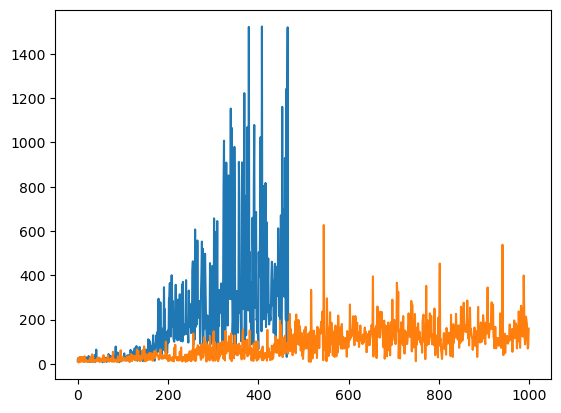

In [30]:
plt.plot(steps)
plt.plot(steps_no_baseline)